股票: 全友2305，京城銀       2809

時間	20230103-20231128
```
Y
個股報酬率％

X	
本益比-TEJ
成交量(千股)
外資買賣超(千股)
投信買賣超(千股)
自營買賣超(千股)
美國納斯達克報酬率
大盤報酬率
台北外匯美元即期交易-收盤價	
```

In [1]:
from datetime import datetime
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import pickle
import datetime
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
NASDAQ_table = pd.read_csv('./NASDAQ.txt', encoding='cp950')
foreign_table = pd.read_csv('./foreign.txt', encoding='cp950')
stock_price_table = pd.read_csv('./price.txt', encoding='cp950')
stock_chip_table = pd.read_csv('./chip.txt', encoding='cp950')

In [3]:
NASDAQ_table = NASDAQ_table.rename(columns={
    "代碼": 'code',
    "簡稱": 'name',
    "年月": 'date',
    '漲跌幅%': 'return'
})
foreign_table = foreign_table.rename(columns={
    "代碼": 'code',
    "簡稱": 'name',
    "年月日": 'date',
    '即期交易 - 收盤價': 'exchange'
})

stock_price_table = stock_price_table.rename(columns={
   '證券代碼': 'code',
    '簡稱': 'name',
    "年月日": 'date',
    'TSE新產業_名稱':"industry", 
    '報酬率％': 'return', 
    '成交量(千股)': 'volume', 
    '本益比-TEJ': 'PE',
})

stock_chip_table = stock_chip_table.rename(columns={
   '證券名稱': 'code',
    '簡稱': 'name',
    "年月日": 'date',
    '外資買賣超(千股)':"foreign_investors", 
    '投信買賣超(千股)': 'investment_trust', 
    '自營買賣超(千股)': 'dealer'
})

In [4]:
def convertDummy(x):
    if x == '電腦及週邊': return 0
    elif x == '金融業    ' : return 1
    else: return None
    
def convertFloat(x):
    try: return float(x)
    except ValueError: return None

def convertInt(x):
    try: return int(x)
    except ValueError: return None

def convertStr(x):
    try: return str(x).strip()
    except ValueError: return None
    

NASDAQ_table['code'] = NASDAQ_table['code'].apply(convertStr)
NASDAQ_table['date'] = NASDAQ_table['date'].apply(convertStr)
NASDAQ_table['return'] = NASDAQ_table['return'].apply(convertFloat)

foreign_table['date'] = foreign_table['date'].apply(convertStr)
foreign_table['exchange'] = foreign_table['exchange'].apply(convertFloat)

stock_price_table['code'] = stock_price_table['code'].apply(convertStr)
stock_price_table['date'] = stock_price_table['date'].apply(convertStr)
stock_price_table['industry'] = stock_price_table['industry'].apply(convertDummy)
stock_price_table['return'] = stock_price_table['return'].apply(convertFloat)
stock_price_table['PE'] = stock_price_table['PE'].apply(convertFloat)
stock_price_table['volume'] = stock_price_table['volume'].apply(convertInt)


stock_chip_table['code'] = stock_chip_table['code'].apply(convertStr)
stock_chip_table['date'] = stock_chip_table['date'].apply(convertStr)

stock_chip_table['foreign_investors'] = stock_chip_table['foreign_investors'].apply(convertInt)
stock_chip_table['investment_trust'] = stock_chip_table['investment_trust'].apply(convertInt)
stock_chip_table['dealer'] = stock_chip_table['dealer'].apply(convertInt)

In [159]:
NASDAQ_table

,code,name,date,return
0,SB56,美國NASDAQ Composite指數,20221205,-1.9331
1,SB5602,美國NASDAQ 100指數,20221205,-1.7297
2,SB57,美國NASDAQ Computer指數,20221205,-1.4656
3,SB56,美國NASDAQ Composite指數,20221206,-2.0022
4,SB5602,美國NASDAQ 100指數,20221206,-2.0117
...,...,...,...,...
744,SB5602,美國NASDAQ 100指數,20231130,-0.2485
745,SB57,美國NASDAQ Computer指數,20231130,-0.5941
746,SB56,美國NASDAQ Composite指數,20231201,0.5540
747,SB5602,美國NASDAQ 100指數,20231201,0.3117


In [5]:
stock_price_2305 = stock_price_table[stock_price_table['code']  == '2305'][['code', 'name', 'industry', 'date', 'return', 'volume', 'PE']]
stock_price_2809 = stock_price_table[stock_price_table['code']  == '2809'][['code', 'name', 'industry', 'date', 'return', 'volume', 'PE']]
stock_price_tw_ret = stock_price_table[stock_price_table['code']  == 'Y9999'][['date', 'return']].rename(columns={'return': 'TW_market'})

NASDAQ_ret = NASDAQ_table.query('code == "SB56"')[['date', 'return']].rename(columns={'return': 'NASDAQ_market'})

In [6]:
stock_chip_table_2305 = stock_chip_table[stock_chip_table['code']  == '2305']
stock_chip_table_2809 = stock_chip_table[stock_chip_table['code']  == '2809']


stock_price_chip_2305 = stock_price_2305.merge(
    stock_price_tw_ret, on=['date',], 
    how='left'
).merge(
    foreign_table[['date', 'exchange']], on=['date',], 
    how='left'
).merge(
    stock_chip_table_2305, on=['code', 'name', 'date'], 
    how='left'
).merge(
    NASDAQ_ret, on=['date'], 
    how='left'
)

stock_price_chip_2809 = stock_price_2809.merge(
    stock_price_tw_ret, on=['date',], 
    how='left'
).merge(
    foreign_table[['date', 'exchange']], on=['date',], 
    how='left'
).merge(
    stock_chip_table_2809, on=['code', 'name', 'date'], 
    how='left'
).merge(
    NASDAQ_ret, on=['date'], 
    how='left'
)

In [7]:
research_data = stock_price_chip_2305.append(stock_price_chip_2809).dropna().sort_values('date').reset_index(drop=True)
research_data = research_data[(research_data['date'] >= '20230103')&(research_data['date'] <= '20231128')]

In [8]:
X_col = [
    'PE', 
    'volume', 
    'foreign_investors', 
    'investment_trust', 
    'dealer',
    'NASDAQ_market',
    'TW_market',
    'exchange',
    'industry',
]

In [9]:
from scipy import stats

def describeData(data: pd.DataFrame, nan_policy='omit'):
    sk = stats.skew(data, nan_policy='omit')
    kurt = stats.kurtosis(data, nan_policy='omit')
    
    sk_values = sk if isinstance(sk, np.ndarray) else sk.data
    kurt_values = kurt if isinstance(kurt, np.ndarray) else kurt.data
    
    describe_result = data.describe().append(
        pd.DataFrame([sk_values], index=['skew'], columns=data.columns)
    ).append(
        pd.DataFrame([kurt_values], index=['kurtosis'], columns=data.columns)
    )
    return describe_result

基本敘述 跟 畫圖

In [10]:
research_data

,code,name,industry,date,return,volume,PE,TW_market,exchange,foreign_investors,investment_trust,dealer,NASDAQ_market
38,2809,京城銀,1.0,20230103,-1.0324,525,45.8497,0.6113,30.698,-207.0,1.0,11.0,-0.7595
39,2305,全友,0.0,20230103,2.9354,731,89.1833,0.6113,30.698,338.0,0.0,-6.0,-0.7595
40,2809,京城銀,1.0,20230104,-0.1490,769,45.7814,-0.1757,30.714,-332.0,0.0,20.0,0.6910
41,2305,全友,0.0,20230104,1.5209,806,90.5397,-0.1757,30.714,106.0,0.0,0.0,0.6910
42,2305,全友,0.0,20230105,-2.4345,611,88.3356,0.7178,30.710,-125.0,0.0,-5.0,-1.4679
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,2809,京城銀,1.0,20231121,1.9506,3228,11.7439,1.1983,31.448,2032.0,-53.0,-201.0,-0.5919
411,2809,京城銀,1.0,20231122,1.1480,2373,11.8787,-0.6111,31.595,1290.0,190.0,7.0,0.4639
412,2809,京城銀,1.0,20231124,-0.1269,721,11.7889,-0.0412,31.628,-7.0,-4.0,-33.0,-0.1051
413,2809,京城銀,1.0,20231127,0.3812,1156,11.8338,-0.8677,31.570,384.0,0.0,-15.0,-0.0690


In [161]:
!python --version

Python 3.7.16


In [165]:
# describeData(research_data[['return',*X_col]]).to_excel('describeData.xlsx')
describeData(research_data[['return',*X_col]])

,return,PE,volume,foreign_investors,investment_trust,dealer,NASDAQ_market,TW_market,exchange,industry
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,0.016222,180.418407,993.994695,51.726790,33.814324,6.400531,0.131513,0.079406,31.099942,0.551724
std,1.744799,265.053030,950.064063,385.308963,218.214472,143.200913,1.134378,0.829644,0.692626,0.497978
min,-5.814000,11.114800,53.000000,-3036.000000,-591.000000,-842.000000,-2.502400,-1.854100,29.700000,0.000000
25%,-0.750000,13.507100,388.000000,-72.000000,0.000000,-6.000000,-0.631000,-0.455300,30.593000,0.000000
50%,0.000000,48.309600,721.000000,13.000000,0.000000,0.000000,0.116400,0.071900,30.790000,1.000000
75%,0.558700,87.996500,1250.000000,150.000000,0.000000,12.000000,0.842300,0.585800,31.854000,1.000000
max,10.000000,778.184500,6969.000000,2050.000000,3364.000000,1195.000000,3.254000,3.756100,32.484000,1.000000
skew,2.016141,1.395394,2.633598,-0.510185,10.679785,1.341515,0.026316,0.382091,0.393979,-0.208013
kurtosis,11.257668,0.039478,9.206668,18.975058,147.534346,21.851477,-0.412748,1.567093,-1.083925,-1.956731


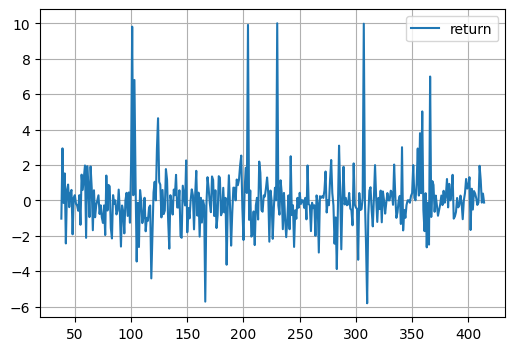

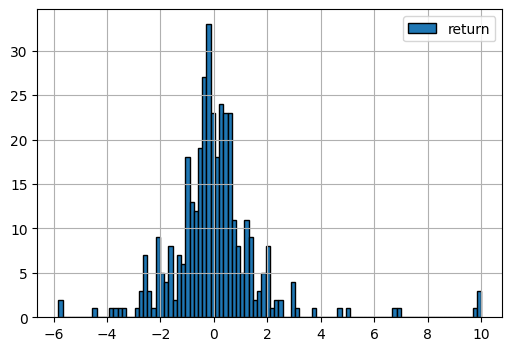

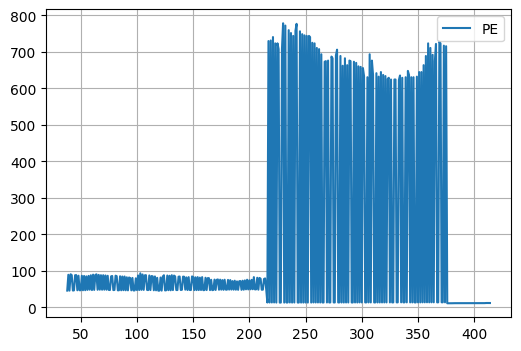

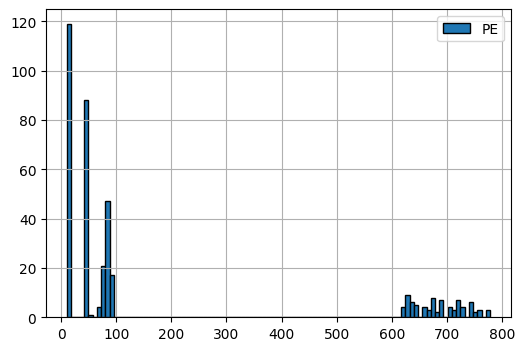

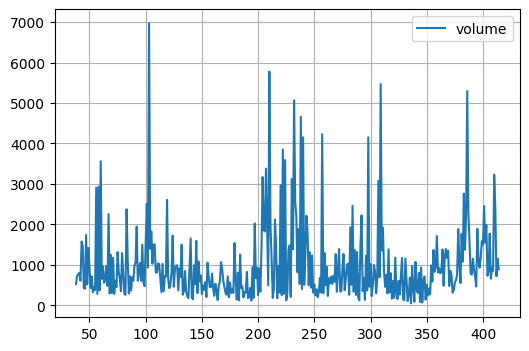

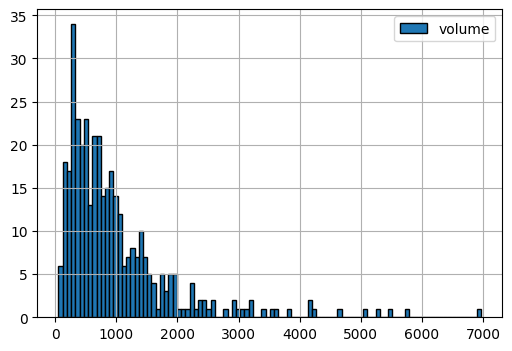

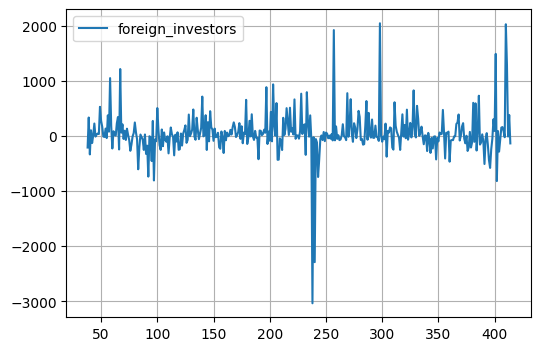

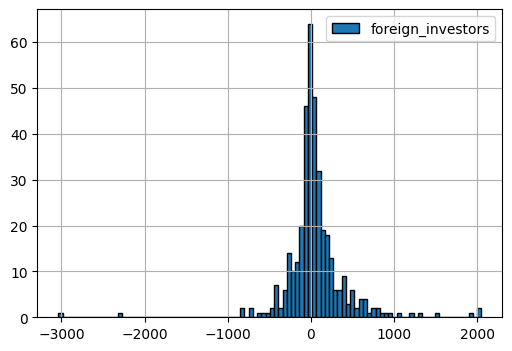

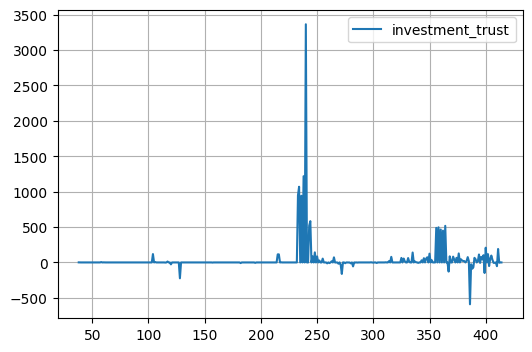

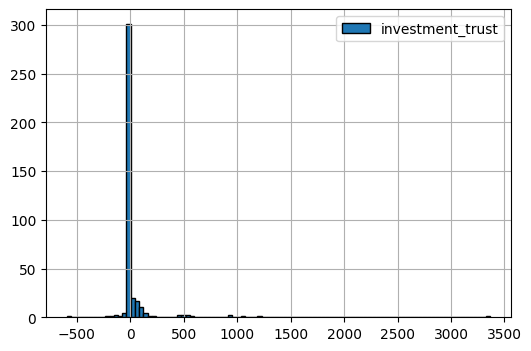

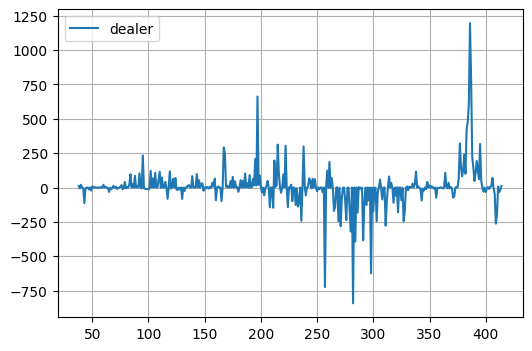

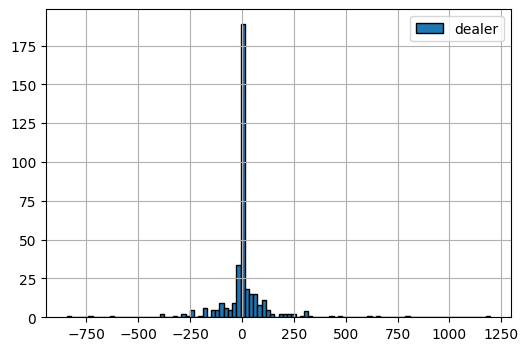

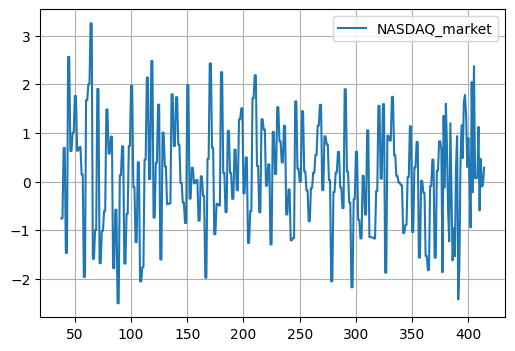

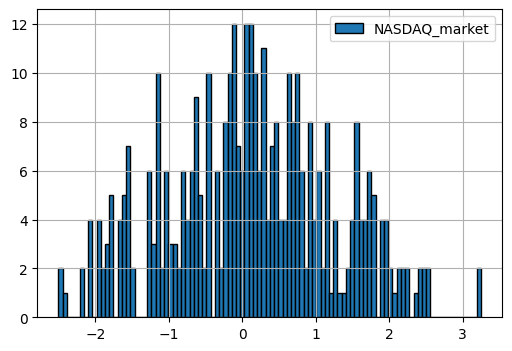

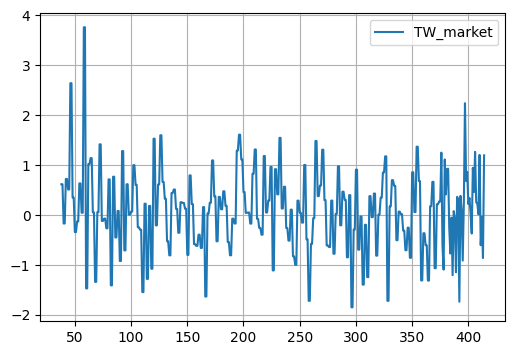

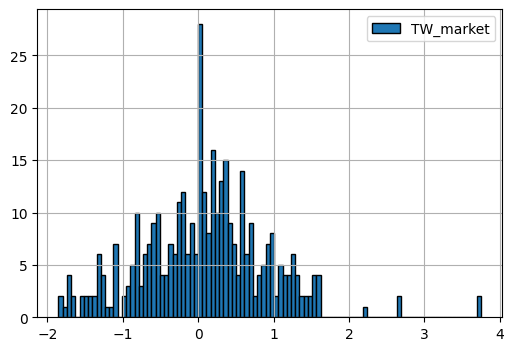

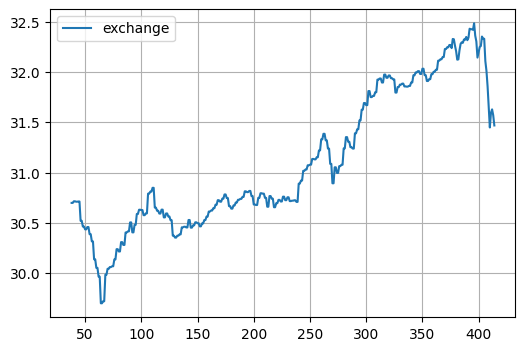

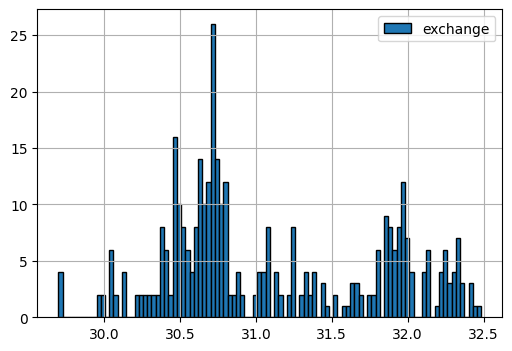

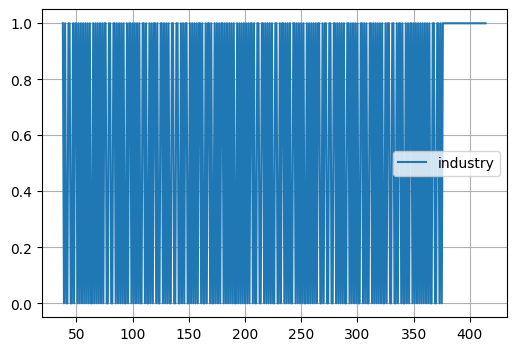

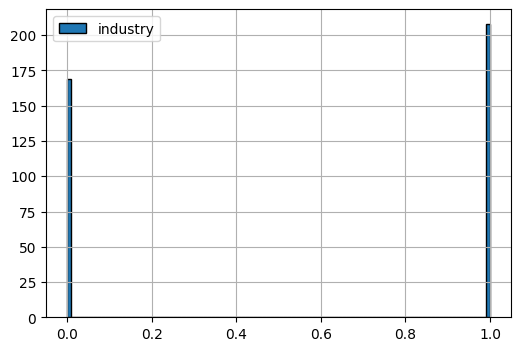

In [166]:
for x in ['return',*X_col]:
    plt.figure(figsize=(6, 4))
    plt.plot(research_data[x], label=x)
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(research_data[x], label=x, bins=100, edgecolor = 'black',)
    plt.legend()
    plt.grid()
    plt.show()

# 跑回歸

# 全模型

In [169]:
full_model_results = sm.OLS(research_data['return'], sm.add_constant(research_data[X_col])).fit()
full_model_resid = full_model_results.resid
full_model_resid.name = 'full_model_resid'
print("SSR:", full_model_results.ssr)
full_model_results.summary()

SSR: 941.0289087590091


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.824
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.77e-12
Time:                        09:50:35   Log-Likelihood:                -707.37
No. Observations:                 377   AIC:                             1435.
Df Residuals:                     367   BIC:                             1474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.4423      4.085     -1.088      0.278     -12.475       3.590
PE                    0.0002      0.000      0.467      0.641      -0.001       0.001
volume                0.0004   9.54e-05      3.912      0.000       0.000       0.001
foreign_investors     0.0014      0.000      5.685      0.000       0.001       0.002
investment_trust      0.0008      0.000      1.792      0.074   -7.71e-05       0.002
dealer                0.0008      0.001      1.358      0.175      -0.000       0.002
NASDAQ_market         0.0747      0.074      1.012      0.312      -0.070       0.220
TW_market             0.3909      0.101      3.860      0.000       0.192       0.590
exchange              0.1304      0.134      0.976      0.330      -0.132       0.393
industry             -0.2775      0.242     -1.144      0.253      -0.754       0.199
==============================================================================
Omnibus:                      187.749   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2119.709
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      14.038   Cond. No.                     6.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 共線性處理

In [14]:
import pandas as pd
import numpy as np


corr = research_data[['return', *X_col]].corr()

corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,return,PE,volume,foreign_investors,investment_trust,dealer,NASDAQ_market,TW_market,exchange,industry
return,1.000000,-0.007284,0.231829,0.289130,-0.002885,-0.005210,0.061242,0.209256,0.028390,0.035948
PE,-0.007284,1.000000,-0.224798,-0.096324,-0.097985,-0.021618,-0.038729,-0.059042,0.204821,-0.640349
volume,0.231829,-0.224798,1.000000,0.093130,0.223224,0.075449,-0.032667,0.025782,0.023485,0.319653
foreign_investors,0.289130,-0.096324,0.093130,1.000000,-0.390369,-0.194534,0.057126,0.098431,-0.006206,0.138080
investment_trust,-0.002885,-0.097985,0.223224,-0.390369,1.000000,-0.071668,-0.029961,-0.026016,0.019772,0.139864
dealer,-0.005210,-0.021618,0.075449,-0.194534,-0.071668,1.000000,-0.091346,-0.086530,0.084121,0.039261
NASDAQ_market,0.061242,-0.038729,-0.032667,0.057126,-0.029961,-0.091346,1.000000,0.092875,-0.100313,0.004432
TW_market,0.209256,-0.059042,0.025782,0.098431,-0.026016,-0.086530,0.092875,1.000000,-0.122570,0.009634
exchange,0.028390,0.204821,0.023485,-0.006206,0.019772,0.084121,-0.100313,-0.122570,1.000000,0.159932
industry,0.035948,-0.640349,0.319653,0.138080,0.139864,0.039261,0.004432,0.009634,0.159932,1.000000


volume on foreign_investors, investment_trust

In [15]:
vol_on_fi_res = sm.OLS(
    research_data['volume'], 
    sm.add_constant(research_data['foreign_investors'])
).fit()
print(1/(1 - vol_on_fi_res.rsquared))
vol_on_fi_res.summary()

1.0087491307011633


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.281
Date:                Fri, 12 Jan 2024   Prob (F-statistic):             0.0709
Time:                        02:23:04   Log-Likelihood:                -3117.7
No. Observations:                 377   AIC:                             6239.
Df Residuals:                     375   BIC:                             6247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               982.1165     49.222     19.953      0.000     885.331    1078.902
foreign_investors     0.2296      0.127      1.811      0.071      -0.020       0.479
==============================================================================
Omnibus:                      245.882   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2095.295
Skew:                           2.757   Prob(JB):                         0.00
Kurtosis:                      13.148   Cond. No.                         392.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
vol_on_it_res = sm.OLS(
    research_data['volume'], 
    sm.add_constant(research_data['investment_trust'])
).fit()
print(1/(1 - vol_on_it_res.rsquared))
vol_on_it_res.summary()

1.0524420292626173


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     19.67
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           1.21e-05
Time:                        02:23:04   Log-Likelihood:                -3109.7
No. Observations:                 377   AIC:                             6223.
Df Residuals:                     375   BIC:                             6231.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              961.1314     48.331     19.886      0.000     866.097    1056.166
investment_trust     0.9719      0.219      4.435      0.000       0.541       1.403
==============================================================================
Omnibus:                      252.438   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2333.514
Skew:                           2.819   Prob(JB):                         0.00
Kurtosis:                      13.806   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

foreign_investors on investment_trust

In [17]:
fi_on_it_res = sm.OLS(
    research_data['foreign_investors'], 
    sm.add_constant(research_data['investment_trust'])
).fit()
print(1/(1 - fi_on_it_res.rsquared))
fi_on_it_res.summary()

1.1797850811200363


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      foreign_investors   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     67.42
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           3.58e-15
Time:                        02:23:24   Log-Likelihood:                -2747.9
No. Observations:                 377   AIC:                             5500.
Df Residuals:                     375   BIC:                             5508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               75.0346     18.513      4.053      0.000      38.632     111.437
investment_trust    -0.6893      0.084     -8.211      0.000      -0.854      -0.524
==============================================================================
Omnibus:                      154.810   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2323.787
Skew:                           1.303   Prob(JB):                         0.00
Kurtosis:                      14.880   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 刪除變數

## 假設非異質變數

假設為常態分配->利用 F-test

In [18]:
full_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.824
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.77e-12
Time:                        02:23:29   Log-Likelihood:                -707.37
No. Observations:                 377   AIC:                             1435.
Df Residuals:                     367   BIC:                             1474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.4423      4.085     -1.088      0.278     -12.475       3.590
PE                    0.0002      0.000      0.467      0.641      -0.001       0.001
volume                0.0004   9.54e-05      3.912      0.000       0.000       0.001
foreign_investors     0.0014      0.000      5.685      0.000       0.001       0.002
investment_trust      0.0008      0.000      1.792      0.074   -7.71e-05       0.002
dealer                0.0008      0.001      1.358      0.175      -0.000       0.002
NASDAQ_market         0.0747      0.074      1.012      0.312      -0.070       0.220
TW_market             0.3909      0.101      3.860      0.000       0.192       0.590
exchange              0.1304      0.134      0.976      0.330      -0.132       0.393
industry             -0.2775      0.242     -1.144      0.253      -0.754       0.199
==============================================================================
Omnibus:                      187.749   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2119.709
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      14.038   Cond. No.                     6.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
reduce_model_res = sm.OLS(
    research_data['return'], 
    sm.add_constant( research_data[['volume', 'foreign_investors', 'investment_trust', 'TW_market']])
).fit()
# print(1/(1 - reduce_model_res.rsquared))
print("SSR:", reduce_model_res.ssr)
(reduce_model_res.summary())

SSR: 959.7028101796517


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     17.92
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           1.80e-13
Time:                        09:52:07   Log-Likelihood:                -711.07
No. Observations:                 377   AIC:                             1432.
Df Residuals:                     372   BIC:                             1452.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4368      0.120     -3.637      0.000      -0.673      -0.201
volume                0.0003   9.13e-05      3.726      0.000       0.000       0.001
foreign_investors     0.0013      0.000      5.331      0.000       0.001       0.002
investment_trust      0.0006      0.000      1.309      0.191      -0.000       0.001
TW_market             0.3756      0.100      3.743      0.000       0.178       0.573
==============================================================================
Omnibus:                      212.871   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2560.492
Skew:                           2.120   Prob(JB):                         0.00
Kurtosis:                      15.043   Cond. No.                     2.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [173]:
((reduce_model_res.ssr - full_model_results.ssr )/5)/(reduce_model_res.ssr/(reduce_model_res.nobs - 9 - 1))

1.4282175166482858

In [21]:
f_statistic, p_value, df_diff = full_model_results.compare_f_test(reduce_model_res)

In [171]:
 full_model_results.ssr

941.0289087590091

In [172]:
reduce_model_res.nobs

377.0

In [ ]:
Model:return=β_0+β_1 PE+β_2 volume+β_3 foreign_investors+β_4 investment_trust+β_5 dealer+β_6 NASDAQ_market+β_7 TW_market+β_8 exchange+β_9 industry+u

假設為非常態分配->利用LM-test

In [22]:
reduce_model_resid = reduce_model_res.resid
reduce_model_resid.name = 'resid'

In [23]:
lm_test_model_result = sm.OLS(
    reduce_model_resid, 
    sm.add_constant(research_data[X_col])
).fit()
print(1/(1 - lm_test_model_result.rsquared))
lm_test_model_result.summary()

1.0181830843575737


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  resid   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7415
Date:                Fri, 12 Jan 2024   Prob (F-statistic):              0.671
Time:                        02:24:20   Log-Likelihood:                -707.37
No. Observations:                 377   AIC:                             1435.
Df Residuals:                     367   BIC:                             1474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.9962      4.085     -0.978      0.329     -12.029       4.036
PE                    0.0002      0.000      0.467      0.641      -0.001       0.001
volume             3.014e-05   9.54e-05      0.316      0.752      -0.000       0.000
foreign_investors     0.0002      0.000      0.640      0.522      -0.000       0.001
investment_trust      0.0002      0.000      0.521      0.603      -0.001       0.001
dealer                0.0008      0.001      1.358      0.175      -0.000       0.002
NASDAQ_market         0.0175      0.074      0.237      0.813      -0.128       0.162
TW_market             0.0223      0.101      0.220      0.826      -0.177       0.222
exchange              0.1304      0.134      0.976      0.330      -0.132       0.393
industry             -0.2775      0.242     -1.144      0.253      -0.754       0.199
==============================================================================
Omnibus:                      187.749   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2119.709
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      14.038   Cond. No.                     6.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
LM = lm_test_model_result.rsquared * lm_test_model_result.nobs

In [174]:
LM

6.732603308893555

In [25]:
from scipy.stats import chi2
# p_value = 1 - chi2.cdf(lm_statistic, df=3)  # 自由度是被检验的变量数量

In [26]:
1 - chi2.cdf(LM, df = 4)

0.150711885629633

# 假設異質變數

常態分配 ⇒ 利用修正的F-test

In [175]:
# 应用Newey-West标准误差
nw_se = sm.stats.sandwich_covariance.cov_hac(full_model_results)  # maxlags根据数据和情况调整

In [176]:
# 使用调整后的标准误差重新计算t值等统计量
robust_tvalues = full_model_results.params / np.sqrt(np.diag(nw_se))

```
对于 10% 的显著性水平（双尾）：t值约为 ±1.645
对于 5% 的显著性水平（双尾）：t值约为 ±1.960
对于 1% 的显著性水平（双尾）：t值约为 ±2.576
```

In [177]:
robust_tvalues

const               -1.685437
PE                   0.384558
volume               1.738161
foreign_investors    6.590590
investment_trust     2.297682
dealer               1.720543
NASDAQ_market        0.904880
TW_market            4.086195
exchange             1.502984
industry            -0.839913
dtype: float64

In [179]:
# wald_test
hypotheses = 'PE = 0, NASDAQ_market = 0, exchange = 0, industry = 0'
wald_test = full_model_results.wald_test(hypotheses, nw_se)
wald_test.summary()

'<F test: F=array([[1.08075312]]), p=0.36574541235904945, df_denom=367, df_num=4>'

非常態分配 ⇒ 利用 LM-test 

In [181]:
X = research_data[['volume', 'foreign_investors', 'investment_trust', 'NASDAQ_market', 'TW_market']]

lm_PE_results = sm.OLS(research_data['PE'], sm.add_constant(X)).fit()
lm_dealer_results = sm.OLS(research_data['dealer'], sm.add_constant(X)).fit()
lm_NASDAQ_market_results = sm.OLS(research_data['NASDAQ_market'], sm.add_constant(X)).fit()
lm_exchange_results = sm.OLS(research_data['exchange'], sm.add_constant(X)).fit()
lm_industry_results = sm.OLS(research_data['industry'], sm.add_constant(X)).fit()

In [182]:
lm_heteroskedasticity_X = pd.DataFrame()
lm_heteroskedasticity_X['u*PE_resid'] = lm_PE_results.resid * reduce_model_res.resid
lm_heteroskedasticity_X['u*dealer_resid'] = lm_dealer_results.resid * reduce_model_res.resid
lm_heteroskedasticity_X['u*NASDAQ_market'] = lm_NASDAQ_market_results.resid * reduce_model_res.resid
lm_heteroskedasticity_X['u*exchange_resid'] = lm_exchange_results.resid * reduce_model_res.resid
lm_heteroskedasticity_X['u*industry_resid'] = lm_industry_results.resid * reduce_model_res.resid

In [183]:
lm_results_heteroskedasticity = sm.OLS(np.ones(lm_heteroskedasticity_X.shape[0]), lm_heteroskedasticity_X).fit()

In [187]:
print("SSR:",lm_results_heteroskedasticity.ssr)
lm_results_heteroskedasticity.summary()

SSR: 364.02703758243985


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              3.323
Date:                Fri, 12 Jan 2024   Prob (F-statistic):                      0.0108
Time:                        10:27:52   Log-Likelihood:                         -528.34
No. Observations:                 377   AIC:                                      1065.
Df Residuals:                     373   BIC:                                      1080.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
u*PE_resid       -9.336e-05      0.000     -0.645      0.519      -0.000       0.000
u*dealer_resid       0.0014      0.000      3.133      0.002       0.001       0.002
u*NASDAQ_market   2.839e-14    1.3e-14      2.180      0.030    2.78e-15     5.4e-14
u*exchange_resid     0.1106      0.075      1.473      0.141      -0.037       0.258
u*industry_resid    -0.1756      0.080     -2.205      0.028      -0.332      -0.019
==============================================================================
Omnibus:                      206.693   Durbin-Watson:                   0.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6593.339
Skew:                          -1.688   Prob(JB):                         0.00
Kurtosis:                      23.207   Cond. No.                     2.64e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.23e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [185]:
LM_het = lm_results_heteroskedasticity.nobs - lm_results_heteroskedasticity.ssr

In [186]:
LM_het

12.972962417560154

In [37]:
1 - chi2.cdf(LM_het, df = 4)

0.011007799850947353

In [188]:
 lm_results_heteroskedasticity.nobs

377.0

# 殘差的常態分配

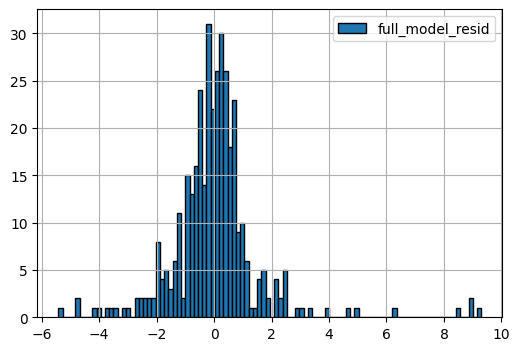

In [38]:
plt.figure(figsize=(6, 4))
plt.hist(full_model_resid, label='full_model_resid', bins=100, edgecolor = 'black',)
plt.legend()
plt.grid()
plt.show()

In [39]:
describeData(full_model_resid.to_frame())

,full_model_resid
count,3.770000e+02
mean,-5.456290e-15
std,1.582004e+00
min,-5.415391e+00
25%,-6.232718e-01
50%,-1.062195e-02
75%,5.385111e-01
max,9.297196e+00
skew,1.810065e+00
kurtosis,1.103795e+01


In [40]:
import scipy.stats as stats

In [41]:
stats.jarque_bera(full_model_resid)

Jarque_beraResult(statistic=2119.708593488722, pvalue=0.0)

In [42]:
stats.normaltest(full_model_resid, axis=0, nan_policy='propagate')

NormaltestResult(statistic=187.74888931234173, pvalue=1.7015577526570477e-41)

# 檢定異質變數

In [43]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

```
lm : float
    The lagrange multiplier statistic.
lm_pvalue :float
    The p-value of lagrange multiplier test.
fvalue : float
    The f-statistic of the hypothesis that the error variance does not
    depend on x. This is an alternative test variant not the original
    LM test.
f_pvalue : float
    The p-value for the f-statistic.
```

In [44]:
white_test = het_white(full_model_results.resid,  full_model_results.model.exog)

In [45]:
white_test

(269.0102708722868,
 5.028139283690377e-31,
 15.521299405517231,
 1.905166016148955e-61)

In [46]:
white_X = research_data[X_col].copy()

# 創建一個包含原始變量、它們的平方和所有交乘項的新數據框架
for col in X_col:
    white_X[col + '^2'] = white_X[col] ** 2


# 添加所有交乘項
for i in range(len(X_col)):
    for j in range(i+1, len(X_col)):
        white_X[f'{X_col[i]}*{X_col[j]}'] = white_X[X_col[i]] * white_X[X_col[j]]

# 進行 White 檢定
full_model_resid_sqr = full_model_resid**2
full_model_resid_sqr.name = 'full_model_resid^2'

white_test_with_cross_result = sm.OLS(full_model_resid_sqr, sm.add_constant(white_X)).fit()
white_test_with_cross_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     full_model_resid^2   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     15.52
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           1.91e-61
Time:                        02:24:54   Log-Likelihood:                -1128.2
No. Observations:                 377   AIC:                             2362.
Df Residuals:                     324   BIC:                             2571.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               -828.4035    895.353     -0.925      0.356   -2589.843     933.036
PE                                     0.2550      0.183      1.394      0.164      -0.105       0.615
volume                                 0.1071      0.025      4.350      0.000       0.059       0.156
foreign_investors                     -0.0766      0.046     -1.653      0.099      -0.168       0.015
investment_trust                      -0.0866      0.138     -0.629      0.530      -0.357       0.184
dealer                                -0.2961      0.253     -1.171      0.243      -0.794       0.201
NASDAQ_market                         -3.8271     12.402     -0.309      0.758     -28.226      20.572
TW_market                             23.6983     18.093      1.310      0.191     -11.896      59.293
exchange                              48.3485     58.826      0.822      0.412     -67.381     164.078
industry                              19.4302     54.484      0.357      0.722     -87.756     126.616
PE^2                               -5.283e-05   3.08e-05     -1.715      0.087      -0.000    7.78e-06
volume^2                           -1.843e-06   2.38e-07     -7.741      0.000   -2.31e-06   -1.37e-06
foreign_investors^2                -3.706e-06   1.78e-06     -2.076      0.039   -7.22e-06   -1.94e-07
investment_trust^2                 -3.701e-05   1.01e-05     -3.652      0.000   -5.69e-05   -1.71e-05
dealer^2                            3.151e-06   6.54e-06      0.482      0.630   -9.71e-06     1.6e-05
NASDAQ_market^2                       -0.1784      0.196     -0.910      0.363      -0.564       0.207
TW_market^2                           -0.0081      0.269     -0.030      0.976      -0.537       0.520
exchange^2                            -0.7050      0.968     -0.728      0.467      -2.610       1.200
industry^2                            19.4302     54.484      0.357      0.722     -87.756     126.616
PE*volume                           3.211e-06   1.69e-06      1.903      0.058   -1.09e-07    6.53e-06
PE*foreign_investors                5.165e-05   1.42e-05      3.633      0.000    2.37e-05    7.96e-05
PE*investment_trust                   -0.0001      0.001     -0.148      0.882      -0.001       0.001
PE*dealer                          -5.754e-05      0.000     -0.217      0.828      -0.001       0.000
PE*NASDAQ_market                       0.0011      0.001      0.755      0.451      -0.002       0.004
PE*TW_market                          -0.0021      0.002     -1.069      0.286      -0.006       0.002
PE*exchange                           -0.0069      0.006     -1.208      0.228      -0.018       0.004
PE*industry                           -0.0138      0.056     -0.245      0.807      -0.125      

In [47]:
# F 檢定的結果
f_test = white_test_with_cross_result.f_pvalue
f_test

1.905166016151175e-61

# White 檢定(無交乘項)

In [48]:
white_X = research_data[X_col].copy()

# 創建一個包含原始變量、它們的平方和所有交乘項的新數據框架
white_test_cols = []
for col in X_col:
    white_X[col + '^2'] = white_X[col] ** 2
    white_test_cols.append(col + '^2')

# # 添加所有交乘項
# for i in range(len(X_col)):
#     for j in range(i+1, len(X_col)):
#         white_X[f'{X_col[i]}*{X_col[j]}'] = white_X[X_col[i]] * white_X[X_col[j]]

# 進行 White 檢定
full_model_resid_sqr = full_model_resid**2
full_model_resid_sqr.name = 'full_model_resid^2'

white_test_no_cross_result = sm.OLS(full_model_resid_sqr, sm.add_constant(white_X[white_test_cols])).fit()
white_test_no_cross_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     full_model_resid^2   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     9.317
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           9.05e-13
Time:                        02:24:54   Log-Likelihood:                -1325.0
No. Observations:                 377   AIC:                             2670.
Df Residuals:                     367   BIC:                             2709.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.9454     10.575     -0.468      0.640     -25.741      15.850
PE^2                 2.054e-06   2.97e-06      0.692      0.490   -3.78e-06    7.89e-06
volume^2             7.682e-07   1.06e-07      7.242      0.000     5.6e-07    9.77e-07
foreign_investors^2 -1.466e-06    7.8e-07     -1.880      0.061      -3e-06    6.75e-08
investment_trust^2  -4.438e-07   8.17e-07     -0.544      0.587   -2.05e-06    1.16e-06
dealer^2            -1.043e-05   4.67e-06     -2.230      0.026   -1.96e-05   -1.23e-06
NASDAQ_market^2         0.2354      0.266      0.886      0.376      -0.287       0.758
TW_market^2            -0.1509      0.326     -0.463      0.644      -0.792       0.490
exchange^2              0.0086      0.011      0.769      0.443      -0.013       0.031
industry^2             -4.1681      1.149     -3.627      0.000      -6.428      -1.908
==============================================================================
Omnibus:                      512.287   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50415.081
Skew:                           6.806   Prob(JB):                         0.00
Kurtosis:                      57.993   Cond. No.                     1.25e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# F 檢定的結果
f_test = white_test_no_cross_result.f_pvalue
f_test

9.047444876802118e-13

異質性的White檢定的特例

In [50]:
full_model_resid_sqr = full_model_resid**2
full_model_resid_sqr.name = 'full_model_resid^2'

In [51]:
y_hat  = research_data['return'] - full_model_resid
y_hat_sqr = y_hat**2

In [52]:
white_test_special_X = pd.DataFrame()
white_test_special_X['y_hat'] = y_hat 
white_test_special_X['y_hat^2'] = y_hat_sqr 

In [53]:
white_test_special_result = sm.OLS(full_model_resid_sqr, sm.add_constant(white_test_special_X)).fit()
white_test_special_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     full_model_resid^2   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     6.977
Date:                Fri, 12 Jan 2024   Prob (F-statistic):            0.00106
Time:                        02:24:56   Log-Likelihood:                -1356.9
No. Observations:                 377   AIC:                             2720.
Df Residuals:                     374   BIC:                             2732.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6685      0.506      5.273      0.000       1.673       3.663
y_hat          2.7358      0.802      3.411      0.001       1.159       4.313
y_hat^2       -0.4011      0.414     -0.968      0.334      -1.216       0.414
==============================================================================
Omnibus:                      517.487   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50260.977
Skew:                           6.948   Prob(JB):                         0.00
Kurtosis:                      57.832   Cond. No.                         3.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [189]:
white_test_special_result.nobs * white_test_special_result.rsquared

13.560306061861613

 Breusch-Pagan檢定

In [55]:
full_model_resid_sqr = full_model_resid**2
full_model_resid_sqr.name = 'full_model_resid^2'

In [56]:
BP_test_result = sm.OLS(full_model_resid_sqr, sm.add_constant(research_data[X_col])).fit()
BP_test_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     full_model_resid^2   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     13.08
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           3.75e-18
Time:                        02:24:57   Log-Likelihood:                -1311.4
No. Observations:                 377   AIC:                             2643.
Df Residuals:                     367   BIC:                             2682.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -10.6531     20.276     -0.525      0.600     -50.525      29.219
PE                    0.0015      0.002      0.665      0.506      -0.003       0.006
volume                0.0043      0.000      9.036      0.000       0.003       0.005
foreign_investors    -0.0003      0.001     -0.250      0.803      -0.003       0.002
investment_trust     -0.0038      0.002     -1.724      0.086      -0.008       0.001
dealer               -0.0024      0.003     -0.807      0.420      -0.008       0.004
NASDAQ_market         0.4093      0.366      1.118      0.264      -0.311       1.129
TW_market            -0.7568      0.503     -1.505      0.133      -1.745       0.232
exchange              0.3984      0.664      0.600      0.549      -0.907       1.704
industry             -6.5121      1.204     -5.411      0.000      -8.879      -4.145
==============================================================================
Omnibus:                      482.227   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39629.650
Skew:                           6.158   Prob(JB):                         0.00
Kurtosis:                      51.695   Cond. No.                     6.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [190]:
BP_test_result.rsquared

0.24291171168764114

In [57]:
BP_test_result.nobs * BP_test_result.rsquared

91.5777153062407

In [58]:
full_model_results.model.exog.shape

(377, 10)

In [60]:
het_breuschpagan(full_model_resid, full_model_results.model.exog)

(91.5777153062407,
 7.850401431509005e-16,
 13.083546465761062,
 3.750018690426641e-18)

# 修正異質變異數

In [61]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import GLS

In [62]:
full_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.824
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.77e-12
Time:                        02:25:10   Log-Likelihood:                -707.37
No. Observations:                 377   AIC:                             1435.
Df Residuals:                     367   BIC:                             1474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.4423      4.085     -1.088      0.278     -12.475       3.590
PE                    0.0002      0.000      0.467      0.641      -0.001       0.001
volume                0.0004   9.54e-05      3.912      0.000       0.000       0.001
foreign_investors     0.0014      0.000      5.685      0.000       0.001       0.002
investment_trust      0.0008      0.000      1.792      0.074   -7.71e-05       0.002
dealer                0.0008      0.001      1.358      0.175      -0.000       0.002
NASDAQ_market         0.0747      0.074      1.012      0.312      -0.070       0.220
TW_market             0.3909      0.101      3.860      0.000       0.192       0.590
exchange              0.1304      0.134      0.976      0.330      -0.132       0.393
industry             -0.2775      0.242     -1.144      0.253      -0.754       0.199
==============================================================================
Omnibus:                      187.749   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2119.709
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      14.038   Cond. No.                     6.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
# WLS 實現
# 假設權重為殘差的倒數平方
weights = 1.0 / full_model_resid_sqr
model_wls_result = sm.WLS(
    research_data['return'],
    sm.add_constant(research_data[X_col]), 
    weights=weights
).fit()

In [64]:
model_wls_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.980
Model:                            WLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1964.
Date:                Fri, 12 Jan 2024   Prob (F-statistic):          2.80e-304
Time:                        02:25:11   Log-Likelihood:                -282.10
No. Observations:                 377   AIC:                             584.2
Df Residuals:                     367   BIC:                             623.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.5617      0.295    -15.460      0.000      -5.142      -3.981
PE                    0.0002    4.9e-05      4.700      0.000       0.000       0.000
volume                0.0004    5.5e-06     68.638      0.000       0.000       0.000
foreign_investors     0.0014   2.36e-05     60.179      0.000       0.001       0.001
investment_trust      0.0009   5.64e-05     15.573      0.000       0.001       0.001
dealer                0.0008   4.47e-05     18.349      0.000       0.001       0.001
NASDAQ_market         0.0755      0.005     15.308      0.000       0.066       0.085
TW_market             0.3976      0.007     57.166      0.000       0.384       0.411
exchange              0.1338      0.010     13.710      0.000       0.115       0.153
industry             -0.2662      0.025    -10.736      0.000      -0.315      -0.217
==============================================================================
Omnibus:                     1693.484   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.868
Skew:                           0.024   Prob(JB):                     6.06e-14
Kurtosis:                       1.032   Cond. No.                     1.16e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
# FGLS 實現
# 1. 使用 OLS 估計殘差的變異數結構
# 2. 使用估計的變異數結構進行 GLS
predicted_variance = full_model_results.predict( sm.add_constant(research_data[X_col]) ) ** 2

sigma_f = np.diag(predicted_variance)
model_fgls_result = GLS( research_data['return'], research_data[X_col], sigma=sigma_f).fit()

In [192]:
predicted_variance

38      0.376653
39      0.263169
40      0.795364
41      0.000311
42      0.040780
         ...    
410    13.739340
411     4.340482
412     0.150029
413     0.000547
414     0.000687
Length: 377, dtype: float64

In [191]:
?np.diag

In [66]:
model_fgls_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                 return   R-squared (uncentered):                   0.720
Model:                            GLS   Adj. R-squared (uncentered):              0.713
Method:                 Least Squares   F-statistic:                              105.1
Date:                Fri, 12 Jan 2024   Prob (F-statistic):                    5.00e-96
Time:                        02:25:34   Log-Likelihood:                         -1163.7
No. Observations:                 377   AIC:                                      2345.
Df Residuals:                     368   BIC:                                      2381.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
PE                    0.0040      0.000     12.792      0.000       0.003       0.005
volume                0.0007      0.000      3.286      0.001       0.000       0.001
foreign_investors     0.0069      0.001      7.937      0.000       0.005       0.009
investment_trust      0.0048      0.001      8.663      0.000       0.004       0.006
dealer                0.0024      0.001      1.759      0.079      -0.000       0.005
NASDAQ_market        -0.0037      0.068     -0.055      0.956      -0.137       0.129
TW_market             1.6064      0.216      7.444      0.000       1.182       2.031
exchange             -0.0839      0.009     -9.760      0.000      -0.101      -0.067
industry              0.9598      0.171      5.598      0.000       0.623       1.297
==============================================================================
Omnibus:                      304.477   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18436.179
Skew:                           2.827   Prob(JB):                         0.00
Kurtosis:                      36.789   Cond. No.                     6.11e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Chow test

In [ ]:
介紹：用來判斷資料內區分不同群組後，是否有顯著的差異
步驟：
     (1)將資料分割成前後兩部跑迴歸跑 OLS 時改變不同資料範圍
     (2)連同完整資料可算出 F值
        F=[SSR_p-(SSR1+SSR2)]SSR1+SSR2 [n-2(k+1)]k
完整資料共188筆分成兩份，第一份為第一天至第五十九天，第二份為第六十天至一百一十八天


In [68]:
research_data['date'].drop_duplicates()

38     20230103
40     20230104
42     20230105
44     20230106
46     20230109
         ...   
410    20231121
411    20231122
412    20231124
413    20231127
414    20231128
Name: date, Length: 208, dtype: object

In [72]:
gate = research_data['date'].drop_duplicates().values[208//2]

In [90]:
gate

'20230627'

In [73]:
sample_1 = research_data[research_data['date'] <= gate]
sample_2 = research_data[research_data['date'] > gate]

In [194]:
sample_2

,code,name,industry,date,return,volume,PE,TW_market,exchange,foreign_investors,investment_trust,dealer,NASDAQ_market
248,2809,京城銀,1.0,20230628,0.1414,1234,13.0642,0.2826,31.072,75.0,142.0,61.0,0.2662
249,2305,全友,0.0,20230628,-0.4202,315,745.1708,0.2826,31.072,-91.0,0.0,0.0,0.2662
250,2809,京城銀,1.0,20230629,0.4237,519,13.1196,0.0394,31.078,64.0,85.0,-27.0,-0.0031
251,2305,全友,0.0,20230629,-0.2110,254,743.5987,0.0394,31.078,47.0,0.0,0.0,-0.0031
252,2809,京城銀,1.0,20230630,0.0000,396,13.1196,-0.1579,31.135,-39.0,27.0,-12.0,1.4464
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,2809,京城銀,1.0,20231121,1.9506,3228,11.7439,1.1983,31.448,2032.0,-53.0,-201.0,-0.5919
411,2809,京城銀,1.0,20231122,1.1480,2373,11.8787,-0.6111,31.595,1290.0,190.0,7.0,0.4639
412,2809,京城銀,1.0,20231124,-0.1269,721,11.7889,-0.0412,31.628,-7.0,-4.0,-33.0,-0.1051
413,2809,京城銀,1.0,20231127,0.3812,1156,11.8338,-0.8677,31.570,384.0,0.0,-15.0,-0.0690


In [198]:
sample_1_ols_result = sm.OLS(sample_1['return'], sm.add_constant(sample_1[X_col])).fit()
print("SSR:", sample_1_ols_result.ssr)
sample_1_ols_result.summary()

SSR: 580.966020166943


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     5.689
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           5.15e-07
Time:                        11:23:56   Log-Likelihood:                -404.82
No. Observations:                 210   AIC:                             829.6
Df Residuals:                     200   BIC:                             863.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.0044     15.437     -0.454      0.651     -37.444      23.436
PE                -5.856e-06      0.001     -0.008      0.994      -0.001       0.001
volume                0.0005      0.000      3.709      0.000       0.000       0.001
foreign_investors     0.0016      0.000      4.294      0.000       0.001       0.002
investment_trust      0.0006      0.001      1.189      0.236      -0.000       0.002
dealer                0.0015      0.002      0.973      0.332      -0.002       0.004
NASDAQ_market         0.0823      0.098      0.841      0.402      -0.111       0.275
TW_market             0.4236      0.144      2.942      0.004       0.140       0.707
exchange              0.2128      0.506      0.420      0.675      -0.785       1.211
industry             -0.3600      0.275     -1.309      0.192      -0.903       0.182
==============================================================================
Omnibus:                       97.921   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              815.821
Skew:                           1.570   Prob(JB):                    7.03e-178
Kurtosis:                      12.131   Cond. No.                     1.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [197]:
sample_2_ols_result = sm.OLS(sample_2['return'], sm.add_constant(sample_2[X_col])).fit()
print("SSR:", sample_2_ols_result.ssr)
sample_2_ols_result.summary()

SSR: 334.2360284419426


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4.190
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           7.21e-05
Time:                        11:23:45   Log-Likelihood:                -294.90
No. Observations:                 167   AIC:                             609.8
Df Residuals:                     157   BIC:                             641.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -26.5567     11.744     -2.261      0.025     -49.753      -3.360
PE                    0.0138      0.005      2.637      0.009       0.003       0.024
volume                0.0001      0.000      0.732      0.465      -0.000       0.000
foreign_investors     0.0016      0.000      4.169      0.000       0.001       0.002
investment_trust      0.0015      0.001      1.243      0.216      -0.001       0.004
dealer                0.0005      0.001      0.679      0.498      -0.001       0.002
NASDAQ_market         0.0585      0.116      0.503      0.616      -0.171       0.288
TW_market             0.2888      0.149      1.940      0.054      -0.005       0.583
exchange              0.5449      0.325      1.678      0.095      -0.096       1.186
industry              8.6839      3.452      2.516      0.013       1.866      15.502
==============================================================================
Omnibus:                      100.715   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1285.072
Skew:                           1.888   Prob(JB):                    8.92e-280
Kurtosis:                      16.055   Cond. No.                     1.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [195]:
ssr_full = full_model_results.ssr
ssr_s1 = sample_1_ols_result.ssr
ssr_s2 = sample_2_ols_result.ssr
ssr_full, ssr_s1, ssr_s2

(941.0289087590091, 580.966020166943, 334.2360284419426)

In [84]:
chow_statistic = (ssr_full - (ssr_s1 + ssr_s2))/(ssr_s1 + ssr_s2) * (full_model_results.nobs - 2*(len(X_col)+1))/(len(X_col)+1)

In [ ]:
# 計算 Chow 檢定統計量
k = len(model_ols.params)  # 參數數量
N = n  # 總樣本數
chow_statistic = ((RSS - (RSS1 + RSS2)) / len(X_col)) / ((RSS1 + RSS2) / (full_model_results.nobs - 2*len(X_col)))


In [196]:
chow_statistic

1.007448474094747

In [88]:
f_critical = stats.f.ppf(0.95, len(X_col), full_model_results.nobs - 2*len(X_col))

对于 � = 0.05 α=0.05 的显着性水平，双尾检验的 F 临界值为： � � = 0.323 and � � = 2.082 F L ​ =0.323 and F U ​ =2.082

In [94]:
f_critical

1.9059869881134146

In [93]:
 full_model_results.nobs

377.0

# Panel data

In [141]:
panel_data = research_data.sort_values(['code', 'date']).copy().drop(['name', 'industry'], axis=1)

In [142]:
panel_date_maplist = {d : idx for idx, d in enumerate(panel_data['date'].drop_duplicates())}
panel_code_maplist = {"2305": 0, '2809': 1}

In [143]:
panel_data['code'] = panel_data['code'].apply(lambda x : panel_code_maplist[x])
panel_data['date'] = panel_data['date'].apply(lambda x : panel_date_maplist[x])

In [144]:
panel_data

,code,date,return,volume,PE,TW_market,exchange,foreign_investors,investment_trust,dealer,NASDAQ_market
39,0,0,2.9354,731,89.1833,0.6113,30.698,338.0,0.0,-6.0,-0.7595
41,0,1,1.5209,806,90.5397,-0.1757,30.714,106.0,0.0,0.0,0.6910
42,0,2,-2.4345,611,88.3356,0.7178,30.710,-125.0,0.0,-5.0,-1.4679
45,0,3,-0.3839,431,87.9965,0.5055,30.712,-8.0,0.0,0.0,2.5623
46,0,4,0.3854,412,88.3356,2.6359,30.520,28.0,0.0,0.0,0.6279
...,...,...,...,...,...,...,...,...,...,...,...
410,1,203,1.9506,3228,11.7439,1.1983,31.448,2032.0,-53.0,-201.0,-0.5919
411,1,204,1.1480,2373,11.8787,-0.6111,31.595,1290.0,190.0,7.0,0.4639
412,1,205,-0.1269,721,11.7889,-0.0412,31.628,-7.0,-4.0,-33.0,-0.1051
413,1,206,0.3812,1156,11.8338,-0.8677,31.570,384.0,0.0,-15.0,-0.0690


In [145]:
panel_data.set_index(['code', 'date'],inplace = True)

In [146]:
panel_data

return  volume       PE  TW_market  exchange  foreign_investors  \
code date                                                                    
0    0     2.9354     731  89.1833     0.6113    30.698              338.0   
     1     1.5209     806  90.5397    -0.1757    30.714              106.0   
     2    -2.4345     611  88.3356     0.7178    30.710             -125.0   
     3    -0.3839     431  87.9965     0.5055    30.712               -8.0   
     4     0.3854     412  88.3356     2.6359    30.520               28.0   
...           ...     ...      ...        ...       ...                ...   
1    203   1.9506    3228  11.7439     1.1983    31.448             2032.0   
     204   1.1480    2373  11.8787    -0.6111    31.595             1290.0   
     205  -0.1269     721  11.7889    -0.0412    31.628               -7.0   
     206   0.3812    1156  11.8338    -0.8677    31.570              384.0   
     207  -0.1266     890  11.8188     1.1894    31.468             -132.0   

           investment_trust  dealer  NASDAQ_market  
code date                                           
0    0                  0.0    -6.0        -0.7595  
     1                  0.0     0.0         0.6910  
     2                  0.0    -5.0        -1.4679  
     3                  0.0     0.0         2.5623  
     4                  0.0     0.0         0.6279  
...                     ...     ...            ...  
1    203              -53.0  -201.0        -0.5919  
     204              190.0     7.0         0.4639  
     205               -4.0   -33.0        -0.1051  
     206                0.0   -15.0        -0.0690  
     207                0.0    11.0         0.2861  

[377 rows x 9 columns]

In [150]:
panel_data

return  volume       PE  TW_market  exchange  foreign_investors  \
code date                                                                    
0    0     2.9354     731  89.1833     0.6113    30.698              338.0   
     1     1.5209     806  90.5397    -0.1757    30.714              106.0   
     2    -2.4345     611  88.3356     0.7178    30.710             -125.0   
     3    -0.3839     431  87.9965     0.5055    30.712               -8.0   
     4     0.3854     412  88.3356     2.6359    30.520               28.0   
...           ...     ...      ...        ...       ...                ...   
1    203   1.9506    3228  11.7439     1.1983    31.448             2032.0   
     204   1.1480    2373  11.8787    -0.6111    31.595             1290.0   
     205  -0.1269     721  11.7889    -0.0412    31.628               -7.0   
     206   0.3812    1156  11.8338    -0.8677    31.570              384.0   
     207  -0.1266     890  11.8188     1.1894    31.468             -132.0   

           investment_trust  dealer  NASDAQ_market  
code date                                           
0    0                  0.0    -6.0        -0.7595  
     1                  0.0     0.0         0.6910  
     2                  0.0    -5.0        -1.4679  
     3                  0.0     0.0         2.5623  
     4                  0.0     0.0         0.6279  
...                     ...     ...            ...  
1    203              -53.0  -201.0        -0.5919  
     204              190.0     7.0         0.4639  
     205               -4.0   -33.0        -0.1051  
     206                0.0   -15.0        -0.0690  
     207                0.0    11.0         0.2861  

[377 rows x 9 columns]

In [156]:
full_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     8.824
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.77e-12
Time:                        08:20:17   Log-Likelihood:                -707.37
No. Observations:                 377   AIC:                             1435.
Df Residuals:                     367   BIC:                             1474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.4423      4.085     -1.088      0.278     -12.475       3.590
PE                    0.0002      0.000      0.467      0.641      -0.001       0.001
volume                0.0004   9.54e-05      3.912      0.000       0.000       0.001
foreign_investors     0.0014      0.000      5.685      0.000       0.001       0.002
investment_trust      0.0008      0.000      1.792      0.074   -7.71e-05       0.002
dealer                0.0008      0.001      1.358      0.175      -0.000       0.002
NASDAQ_market         0.0747      0.074      1.012      0.312      -0.070       0.220
TW_market             0.3909      0.101      3.860      0.000       0.192       0.590
exchange              0.1304      0.134      0.976      0.330      -0.132       0.393
industry             -0.2775      0.242     -1.144      0.253      -0.754       0.199
==============================================================================
Omnibus:                      187.749   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2119.709
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      14.038   Cond. No.                     6.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [155]:
# 指定自变量和因变量
X = sm.add_constant(panel_data[['PE',
 'volume',
 'foreign_investors',
 'investment_trust',
 'dealer',
 'NASDAQ_market',
 'TW_market',
 'exchange']])
Y = panel_data['return']


# 混合回归
model_pooled = PanelOLS(Y, X, entity_effects=False, time_effects=False)
model_pooled = model_pooled.fit()
print(model_pooled)

# 单向固定效应:设置个体固定效应
model_entity = PanelOLS(Y, X, entity_effects=True, time_effects=False)
model_entity = model_entity.fit()
print(model_entity)

# 单向固定效应:设置时间固定效应
model_time = PanelOLS(Y, X, entity_effects=True, time_effects=False)
model_time = model_time.fit()
print(model_time)

# 双向固定效应:设置个体固定效应和时间固定效应
model_twoway = PanelOLS(Y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
model_twoway = model_twoway.fit()
print(model_twoway)

params = list(model_twoway.params)  # 系数
tvalues = list(model_twoway.tstats)  # 系数t值
pvalues = list(model_twoway.pvalues)  # 系数p值


                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.1750
Estimator:                   PanelOLS   R-squared (Between):             -0.0734
No. Observations:                 377   R-squared (Within):               0.1753
Date:                Fri, Jan 12 2024   R-squared (Overall):              0.1750
Time:                        08:19:19   Log-likelihood                   -708.04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9.7553
Entities:                           2   P-value                           0.0000
Avg Obs:                       188.50   Distribution:                   F(8,368)
Min Obs:                       169.00                                           
Max Obs:                       208.00   F-statistic (robust):             9.7553
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.1651
Estimator:                   PanelOLS   R-squared (Between):              0.4472
No. Observations:                 377   R-squared (Within):               0.1074
Date:                Fri, Jan 12 2024   R-squared (Overall):              0.1079
Time:                        08:19:19   Log-likelihood                   -563.11
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.4485
Entities:                           2   P-value                           0.0000
Avg Obs:                       188.50   Distribution:                   F(5,163)
Min Obs:                       169.00                                           
Max Obs:                       208.00   F-statistic (robust):             6.4485
                            

C:\Users\jeffg\anaconda3\envs\ecm\lib\site-packages\linearmodels\panel\model.py:1833: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

NASDAQ_market, TW_market, exchange

  AbsorbingEffectWarning,


In [199]:
model_twoway

Dep. Variable:,return,R-squared:,0.1651
Estimator:,PanelOLS,R-squared (Between):,0.4472
No. Observations:,377,R-squared (Within):,0.1074
Date:,"Fri, Jan 12 2024",R-squared (Overall):,0.1079
Time:,08:19:19,Log-likelihood,-563.11
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.4485
Entities:,2,P-value,0.0000
Avg Obs:,188.50,Distribution:,"F(5,163)"
Min Obs:,169.00,,
Max Obs:,208.00,F-statistic (robust):,6.4485


In [ ]:
newey-west 修正完整模型的結果
本研究使用 stats.sandwich_covariance.cov_hac 套件處理        

(2)再利用修正變異後的model跑wald-test


In [ ]:
在這個問題中，我們有一個線性回歸模型 
�
=
�
0
+
�
1
�
1
∗
+
�
Y=B 
0
​
 +B 
1
​
 X 
1
∗
​
 +U，其中 
�
1
∗
X 
1
∗
​
  是無法觀測的真實解釋變量，而 
�
1
X 
1
​
  是我們用來替代的觀測變量。假設 
�
=
(
�
1
∗
−
�
1
)
e=(X 
1
∗
​
 −X 
1
​
 ) 表示測量誤差。我們需要根據兩個不同的情況來討論問題：

情況1：
Cov
(
�
1
∗
,
�
)
=
0
Cov(X 
1
∗
​
 ,e)=0

在這個情況下，真實的解釋變量 
�
1
∗
X 
1
∗
​
  與測量誤差 
�
e 之間沒有相關性。這意味著 
�
1
∗
X 
1
∗
​
  的觀測誤差是隨機的，並且不依賴於 
�
1
∗
X 
1
∗
​
  本身的值。在這種情況下，即使我們使用 
�
1
X 
1
​
  來替代 
�
1
∗
X 
1
∗
​
 ，估計的結果仍然是一致的。然而，測量誤差可能會增加估計的變異性，導致估計不那麼精確。

解決方法包括使用更精確的測量方法來減少測量誤差，或者使用統計技術（如測量誤差模型）來校正可能的誤差。

情況2：
Cov
(
�
1
,
�
)
=
0
Cov(X 
1
​
 ,e)=0

在這種情況下，我們使用的觀測變量 
�
1
X 
1
​
  與測量誤差 
�
e 沒有相關性。這種情況通常意味著測量誤差是與 
�
1
X 
1
​
  獨立的。這是一個較為理想的情況，因為它表明即使 
�
1
∗
X 
1
∗
​
  和 
�
1
X 
1
​
  不完全一樣，但 
�
1
X 
1
​
  作為一個代理變量仍然是合適的。在這種情況下，即使存在測量誤差，它也不會對估計結果產生系統性的偏誤。

在這種情況下，可以直接使用 
�
1
X 
1
​
  進行分析，因為它不會引入內生性問題。但如果測量誤差的變異性很大，仍然可能需要考慮使用更精確的測量方法或者進行敏感性分析以評估測量誤差對結果的影響。

總的來說，無論是哪種情況，理解變量間相關性的性質都是關鍵。如果測量誤差與真實變量或觀測變量有相關性，就需要採取適畜的方法來處理這些問題，以確保估計結果的準確性和一致性。